# `MEI`: Encoding model
Here we adapt an encoding model to the MEI dataset. This code uses Himilaya (instead of scikit learn) and is devloped from this tutorial: https://github.com/snastase/encling-tutorial/blob/main/encling_tutorial.ipynb and https://gallantlab.org/voxelwise_tutorials/_auto_examples/shortclips/03_plot_wordnet_model.html

In [1]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import pandas as pd
import json
from scipy.stats import zscore

In [2]:
from nilearn.plotting import view_img

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


### Semantic encoding model
GloVe ([Pennington et al., 2014](http://dx.doi.org/10.3115/v1/D14-1162])) represents each word in a 300-dimensional semantic space where words that are nearer in space are more semantically similar based on co-occurrence statistics from a large corpus of text. We start with a time-stamped stimulus transcript. For each TR, we identify which words occurred in that TR, then assign that TR the semantic embeddings associated with each word. For TRs with multiple words, we average the semantic embeddings; for TRs with no words, we use a 300-dimensional vector of zeros; we exclude a small number of stop words. Finally, to account for the hemodynamic lag in fMRI, we create lagged versions of the embeddings.

In [3]:
# Load in time-stamped transcript
transcript_fn = 'shrek_transcript_final.csv'
transcript = pd.read_csv(transcript_fn, sep=',')

# Stimulus is roughly 800 seconds long
tr = 1.5
stim_dur = 134
stim_trs = int(np.ceil(134 / tr))

# Convert transcript to list for simplicity
transcript = transcript.values.tolist()

# Loop through TRs
transcript_trs = []

In [4]:
print(transcript)

[['okay', 7.6, 7.6], ['let', 8.0, 8.0], ['me', 8.1, 8.1], ['get', 8.2, 8.2], ['this', 8.2, 8.2], ['straight', 8.4, 8.4], ['you', 8.7, 8.8], ['want', 8.8, 9.3], ['to', 9.3, 9.4], ['go', 9.4, 9.5], ['fight', 9.5, 9.8], ['a', 9.8, 9.9], ['dragon', 9.9, 10.2], ['and', 10.2, 10.3], ['rescue', 10.3, 10.8], ['a', 10.8, 10.9], ['princess', 10.9, 11.1], ['just', 11.1, 11.6], ['so', 11.6, 11.6], ['farquad', 11.6, 12.0], ['will', 12.0, 12.1], ['give', 12.2, 12.4], ['you', 12.4, 12.4], ['back', 12.4, 12.6], ['a', 12.6, 12.7], ['swamp', 12.7, 13.2], ['which', 13.2, 13.4], ['you', 13.4, 13.5], ['only', 13.5, 13.8], ["don't", 13.8, 14.1], ['have', 14.1, 14.3], ['cuz', 14.3, 14.5], ['he', 14.5, 14.6], ['filled', 14.6, 14.9], ['it', 14.9, 14.9], ['full', 14.9, 15.1], ['of', 15.1, 15.2], ['freaks', 15.2, 15.2], ['in', 15.2, 15.5], ['the', 15.5, 15.5], ['first', 15.5, 15.8], ['place', 15.8, 16.1], ['that', 16.1, 16.1], ['about', 16.1, 16.1], ['right', 16.2, 16.2], ['you', 16.5, 16.6], ['know', 16.6, 16.6

In [5]:
# Loop through TRs
for t in np.arange(stim_trs):

    # Container for words in this TR
    tr_words = []

    try:
        # Check if upcoming word onset is in this TR
        while t * tr < transcript[0][2] <= t * tr + tr:
            #print(transcript)

            # If so, pop this word out of list and keep it
            w = transcript.pop(0)
            tr_words.append(w[0])
    except:
        transcript_trs.append(tr_words)
        
        continue


    # Append words and move to the next TR
    transcript_trs.append(tr_words)

In [6]:
transcript_trs[5:10]

[['okay', 'let', 'me', 'get', 'this', 'straight', 'you'],
 ['want', 'to', 'go', 'fight', 'a', 'dragon', 'and'],
 ['rescue', 'a', 'princess', 'just', 'so', 'farquad'],
 ['will', 'give', 'you', 'back', 'a', 'swamp', 'which', 'you'],
 ['only', "don't", 'have', 'cuz', 'he', 'filled', 'it']]

## Get glove embeddings for target movie

Use the get_embeddings.ipynb script to produce the shrek_embeddings json

In [7]:
# Load in dictionary of GloVe embeddings
with open('shrek_embeddings.json') as f:
    glove = json.load(f)
    
# Load list of standard stop words
stopwords = np.load('nltk_stopwords.npy')
append = ["farquad", "there's", "let's", "I", "I'm"]
stopwords = np.append(stopwords, append)

In [8]:
print(stopwords)

['i' 'me' 'my' 'myself' 'we' 'our' 'ours' 'ourselves' 'you' "you're"
 "you've" "you'll" "you'd" 'your' 'yours' 'yourself' 'yourselves' 'he'
 'him' 'his' 'himself' 'she' "she's" 'her' 'hers' 'herself' 'it' "it's"
 'its' 'itself' 'they' 'them' 'their' 'theirs' 'themselves' 'what' 'which'
 'who' 'whom' 'this' 'that' "that'll" 'these' 'those' 'am' 'is' 'are'
 'was' 'were' 'be' 'been' 'being' 'have' 'has' 'had' 'having' 'do' 'does'
 'did' 'doing' 'a' 'an' 'the' 'and' 'but' 'if' 'or' 'because' 'as' 'until'
 'while' 'of' 'at' 'by' 'for' 'with' 'about' 'against' 'between' 'into'
 'through' 'during' 'before' 'after' 'above' 'below' 'to' 'from' 'up'
 'down' 'in' 'out' 'on' 'off' 'over' 'under' 'again' 'further' 'then'
 'once' 'here' 'there' 'when' 'where' 'why' 'how' 'all' 'any' 'both'
 'each' 'few' 'more' 'most' 'other' 'some' 'such' 'no' 'nor' 'not' 'only'
 'own' 'same' 'so' 'than' 'too' 'very' 's' 't' 'can' 'will' 'just' 'don'
 "don't" 'should' "should've" 'now' 'd' 'll' 'm' 'o' 're' 've' 'y'

Now that we have a transcript, a dictionary of word embeddings, and a list of stop words, we're ready to construct our predictor matrix. For each TR, obtain the words from `transcript_trs`. If a word is in our list of stop words, ignore it; otherwise, obtain the GloVe embedding for that word. If there are multiple words in a TR (excluding stop words), average their word embeddings to obtain a single embedding per TR. If a TR is empty (i.e. contains no words), set the embedding to a zero vector of the same dimensionality as the other embeddings. Lastly, visualize the resulting predictor matrix; z-score each column (i.e. GloVe dimension) for visualization.

In [9]:
# Assign GloVe embeddings to each TR:
glove_dim = 300

embeddings = []
for t in transcript_trs:
    embeddings_tr = []
    
    # Grab the embedding for each word in a TR
    for w in t:
        
        # Ignore stop words
        if w not in stopwords:
            embeddings_tr.append(np.array(glove[w]).astype(float))
        
    # For non-empty TRs, average the embeddings
    if len(embeddings_tr) > 0:
        embeddings_tr = np.mean(embeddings_tr, axis=0)
    else:
        embeddings_tr = np.zeros(glove_dim)
    embeddings.append(embeddings_tr)

embeddings = np.stack(embeddings, axis=0)

In [10]:
embeddings.shape

(90, 300)

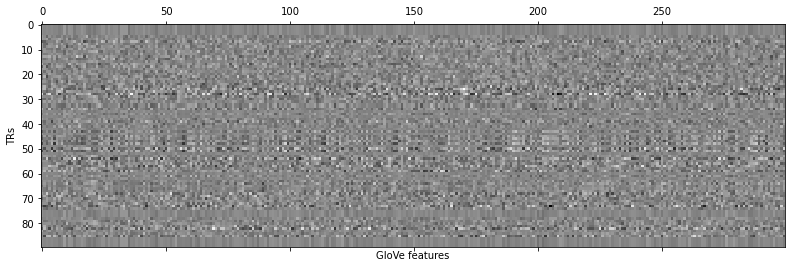

In [11]:
# Visualize predictor matrix of GloVe embeddings:
plt.matshow(zscore(embeddings, axis=0), cmap='binary_r')
plt.xlabel('GloVe features')
plt.ylabel('TRs');

### lags are now handled internally by himalaya **

### Load brain atlas for visualization
We will use a corticalcortical parcellation containing 400 parcels from [Schaefer and colleages (2018)](https://doi.org/10.1093/cercor/bhx179) to reduce the computational load. 
 - Load in the functional data and atlas. 

In [13]:
# Filenames for intact notthefall data and Schaefer atlas
func_fn = ('sub-284_task-black_space-MNI152NLin2009cAsym_res-native_desc-clean_bold.nii.gz')
atlas_fn = ('Schaefer2018_400Parcels_17Networks_order_FSLMNI152_2.5mm.nii.gz')

# Load in the Schaefer 400-parcel atlas
atlas_nii = nib.load(atlas_fn)
atlas_img = atlas_nii.get_fdata()

# All subjects 

### Ridge regression
KernelRidgeCV: this will select the best parameter setting from the inner cross-validation fold within the training half to predict the test half. Higher alpha values increase regularization and reduce overfitting. Within each cross-validation fold, we'll apply two transforms: StandardScaler will be used to mean-center or z-score each column of the predictor matrix within the training set, then apply that transformation to the training set; Delayer will horiztonally stack lagged versions our predictor matrix to account for the hemodynamic lag. We use himalaya's KernelRidgeCV (rather than RidgeCV) because the multi-delayed version of the predictor matrix will be considerably wider than the number of fMRI samples. We'll combine these transforms and the estimator into a Pipeline that will run the whole analysis

In [15]:
# install himalaya if necessary
#!pip install himalaya

Defaulting to user installation because normal site-packages is not writeable
  Using cached himalaya-0.4.2-py3-none-any.whl (83 kB)


In [29]:
# Ridge regression with alpha grid and nested CV:
from sklearn.preprocessing import StandardScaler
#from delayer import Delayer
from sklearn.model_selection import KFold
from himalaya.kernel_ridge import KernelRidgeCV
'''
gotta clone into cur dir to access delayer: git clone: https://github.com/gallantlab/voxelwise_tutorials.git
'''
from voxelwise_tutorials.voxelwise_tutorials.delayer import Delayer 
from sklearn.pipeline import make_pipeline
from himalaya.scoring import correlation_score

from scipy.stats import pearsonr

from sklearn.model_selection import LeaveOneOut
import nibabel as nib
from nilearn.plotting import plot_stat_map
import os


### Run analysis

In [25]:
# List of movies, runs, and data types
#movies = ["office", "cake", "brushing", "sherlock", "origami", "shrek"]
movies = ["shrek"]
runs = range(1, 5)  # Runs 1 to 4
data_types = ['int', 'ext']

# Define the new directory for results
results_dir = 'model1/model_1_results'

# Define the directory where the files are located
data_dir = 'model1/model_1_fmri_data'

# Check if the directory exists; if not, create it
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Define model

In [34]:
# Mean-center each feature (columns of predictor matrix)
scaler = StandardScaler(with_mean=True, with_std=True)

# Create delays at 3, 4.5, 6 seconds (1.5 s TR)
delayer = Delayer(delays=[2, 3, 4])

# Ridge regression with alpha grid and nested CV
alphas = np.logspace(1, 10, 10)
inner_cv = KFold(n_splits=4)
outer_cv = LeaveOneOut()

# Define Model
#ridge = KernelRidgeCV(alphas=alphas, cv=inner_cv) ## inner cv!
ridge = KernelRidgeCV(alphas=alphas)

# Chain transfroms and estimator into pipeline
pipeline = make_pipeline(scaler, delayer, ridge)

Load and make images using one loop

In [31]:
# Define hyperparameters for Ridge regression
#alphas = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
#ridge = RidgeCV(alphas=alphas, scoring='r2')
#loo = LeaveOneOut()
#inner_cv = KFold(n_splits=4)

# Assuming 'trim_emb' and 'atlas_img' are defined and loaded appropriately
# Assuming 'atlas_nii' is the atlas NIfTI image

for mov in movies:
    for run in runs:
        for data_type in data_types:
            file_name = os.path.join(data_dir, f"{data_type}_run_{run}_{mov}_data.npy")
            #file_name = f"{data_type}_run_{run}_{mov}_data.npy"

            # Check if the file exists
            try:
                data = np.load(file_name, allow_pickle=True).item()
                print('data for one sub:', data[run].shape)
            except FileNotFoundError:
                print(f"File {file_name} not found. Skipping...")
                continue

data for one sub: (90, 400)
data for one sub: (90, 400)
data for one sub: (90, 400)
data for one sub: (90, 400)
data for one sub: (90, 400)
data for one sub: (90, 400)
data for one sub: (90, 400)
data for one sub: (90, 400)


In [55]:
# Define hyperparameters for Ridge regression
#alphas = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
#ridge = RidgeCV(alphas=alphas, scoring='r2')


# Assuming 'trim_emb' and 'atlas_img' are defined and loaded appropriately
# Assuming 'atlas_nii' is the atlas NIfTI image

for mov in movies:
    for run in runs:
        for data_type in data_types:
            file_name = os.path.join(data_dir, f"{data_type}_run_{run}_{mov}_data.npy")
            #file_name = f"{data_type}_run_{run}_{mov}_data.npy"

            # Check if the file exists
            try:
                data = np.load(file_name, allow_pickle=True).item()
            except FileNotFoundError:
                print(f"File {file_name} not found. Skipping...")
                continue

            all_subjects = []
            for train_index, test_index in outer_cv.split(data):
                print(f'Training on subjects {train_index}, testing on subject {test_index}')

                # Aggregate training and test data
                train_Y = np.vstack([data[idx] for idx in train_index])
                train_X = np.vstack([embeddings for _ in train_index])

                test_Y = data[test_index[0]]
                test_X = embeddings

                # Fit the model and predict
                #ridge.fit(train_labels, train_data)
                pipeline.fit(train_X, train_Y)
                predicted = pipeline.predict(test_X)

                # Compute correlation
                #r_parcels = [pearsonr(test_data[:, i], predicted[:, i])[0] for i in range(test_data.shape[1])]
                r_parcels = correlation_score(test_Y, predicted)
                all_subjects.append(r_parcels)

            # Processing the results
            matrix_data = np.array(all_subjects)
            average_across_subjects = np.mean(matrix_data, axis=0)

            # Visualize the results
            r_img = np.zeros(atlas_img.shape)
            for i, parcel in enumerate(np.unique(atlas_img)[1:]):
                r_img[atlas_img == parcel] = average_across_subjects[i]

            r_nii = nib.Nifti1Image(r_img, atlas_nii.affine, atlas_nii.header)
            
            # Save the results
            result_file_name = os.path.join(results_dir, f"{data_type}_run_{run}_{mov}_results.npy")
            np.save(result_file_name, average_across_subjects)
            print(f"Saved results to {result_file_name}")


Training on subjects [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18], testing on subject [0]


/usr/people/isaacrc/.local/lib/python3.7/site-packages/himalaya/kernel_ridge/_sklearn_api.py:494: UserWarning: Solving linear kernel ridge is slower than solving ridge when n_samples > n_features (here 1620 > 900). Using himalaya.ridge.RidgeCV would be faster. Use warn=False to silence this warning.
  "Use warn=False to silence this warning.", UserWarning)


KeyboardInterrupt: 

# Banded Ridge

In [38]:
from himalaya.kernel_ridge import Kernelizer, ColumnKernelizer
import random
from himalaya.kernel_ridge import MultipleKernelRidgeCV

In [48]:
nuis_regress = np.array([random.choice([0, 1]) for _ in range(embeddings.shape[0])]).reshape((90,1))


In [49]:
nuis_regress.shape

(90, 1)

In [36]:
embeddings.shape

(90, 300)

### merge models

In [54]:
# Horizontal-stack both embeddings to create joint model
X_joint = np.hstack([embeddings, nuis_regress])
print(f"Joint predictor matrix shape: {X_joint.shape}")

width_m1 = embeddings.shape[1]
width_m2 = nuis_regress.shape[1]

slice_m1 = slice(0, width_m1)
slice_m2 = slice(width_m1, width_m1 + width_m2)
print(f"model 1 slice: {slice_m1}")
print(f"model 2 slice: {slice_m2}")


Joint predictor matrix shape: (90, 301)
model 1 slice: slice(0, 300, None)
model 2 slice: slice(300, 301, None)


### Define model

In [ ]:
## Define cvs
inner_cv = KFold(n_splits=4)
outer_cv = LeaveOneOut()

# Make pipeline with kernelizer for each feature space
column_pipeline = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    Delayer(delays=[2, 3, 4, 5]),
    Kernelizer(kernel="linear"),
)

# Compile joint column kernelizer
column_kernelizer = ColumnKernelizer(
    [('model1', column_pipeline, slice_m1),
     ('model2', column_pipeline, slice_m2)])

In [ ]:
# Ridge regression with alpha grid and nested CV
solver = 'random_search'
n_iter = 20
alphas = np.logspace(1, 10, 10)
solver_params = dict(n_iter=n_iter, alphas=alphas)

# Banded ridge regression with column kernelizer
banded_ridge = MultipleKernelRidgeCV(kernels="precomputed", solver=solver,
                                     solver_params=solver_params, cv=inner_cv)

# Chain transfroms and estimator into pipeline
pipeline = make_pipeline(column_kernelizer, banded_ridge)

### Run 

In [56]:
# Define hyperparameters for Ridge regression
#alphas = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
#ridge = RidgeCV(alphas=alphas, scoring='r2')


# Assuming 'trim_emb' and 'atlas_img' are defined and loaded appropriately
# Assuming 'atlas_nii' is the atlas NIfTI image

for mov in movies:
    for run in runs:
        for data_type in data_types:
            file_name = os.path.join(data_dir, f"{data_type}_run_{run}_{mov}_data.npy")
            #file_name = f"{data_type}_run_{run}_{mov}_data.npy"

            # Check if the file exists
            try:
                data = np.load(file_name, allow_pickle=True).item()
            except FileNotFoundError:
                print(f"File {file_name} not found. Skipping...")
                continue

            all_subjects = []
            for train_index, test_index in outer_cv.split(data):
                print(f'Training on subjects {train_index}, testing on subject {test_index}')

                # Aggregate training and test data
                train_Y = np.vstack([data[idx] for idx in train_index])
                train_X = np.vstack([X_joint for _ in train_index]) # changed

                test_Y = data[test_index[0]]
                test_X = X_joint # Now x-joing

                # Fit the model and predict
                #ridge.fit(train_labels, train_data)
                pipeline.fit(train_X, train_Y)
                predicted = pipeline.predict(test_X)

                # Compute correlation
                #r_parcels = [pearsonr(test_data[:, i], predicted[:, i])[0] for i in range(test_data.shape[1])]
                r_parcels = correlation_score(test_Y, predicted)
                all_subjects.append(r_parcels)

            # Processing the results
            matrix_data = np.array(all_subjects)
            average_across_subjects = np.mean(matrix_data, axis=0)

            # Visualize the results
            r_img = np.zeros(atlas_img.shape)
            for i, parcel in enumerate(np.unique(atlas_img)[1:]):
                r_img[atlas_img == parcel] = average_across_subjects[i]

            r_nii = nib.Nifti1Image(r_img, atlas_nii.affine, atlas_nii.header)
            
            # Save the results
            result_file_name = os.path.join(results_dir, f"{data_type}_run_{run}_{mov}_results.npy")
            np.save(result_file_name, average_across_subjects)
            print(f"Saved results to {result_file_name}")


Training on subjects [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18], testing on subject [0]


/usr/people/isaacrc/.local/lib/python3.7/site-packages/himalaya/kernel_ridge/_sklearn_api.py:494: UserWarning: Solving linear kernel ridge is slower than solving ridge when n_samples > n_features (here 1620 > 903). Using himalaya.ridge.RidgeCV would be faster. Use warn=False to silence this warning.
  "Use warn=False to silence this warning.", UserWarning)


Training on subjects [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18], testing on subject [1]


/usr/people/isaacrc/.local/lib/python3.7/site-packages/himalaya/kernel_ridge/_sklearn_api.py:494: UserWarning: Solving linear kernel ridge is slower than solving ridge when n_samples > n_features (here 1620 > 903). Using himalaya.ridge.RidgeCV would be faster. Use warn=False to silence this warning.
  "Use warn=False to silence this warning.", UserWarning)


Training on subjects [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18], testing on subject [2]


/usr/people/isaacrc/.local/lib/python3.7/site-packages/himalaya/kernel_ridge/_sklearn_api.py:494: UserWarning: Solving linear kernel ridge is slower than solving ridge when n_samples > n_features (here 1620 > 903). Using himalaya.ridge.RidgeCV would be faster. Use warn=False to silence this warning.
  "Use warn=False to silence this warning.", UserWarning)


Training on subjects [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18], testing on subject [3]


/usr/people/isaacrc/.local/lib/python3.7/site-packages/himalaya/kernel_ridge/_sklearn_api.py:494: UserWarning: Solving linear kernel ridge is slower than solving ridge when n_samples > n_features (here 1620 > 903). Using himalaya.ridge.RidgeCV would be faster. Use warn=False to silence this warning.
  "Use warn=False to silence this warning.", UserWarning)


Training on subjects [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18], testing on subject [4]


/usr/people/isaacrc/.local/lib/python3.7/site-packages/himalaya/kernel_ridge/_sklearn_api.py:494: UserWarning: Solving linear kernel ridge is slower than solving ridge when n_samples > n_features (here 1620 > 903). Using himalaya.ridge.RidgeCV would be faster. Use warn=False to silence this warning.
  "Use warn=False to silence this warning.", UserWarning)


Training on subjects [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18], testing on subject [5]


/usr/people/isaacrc/.local/lib/python3.7/site-packages/himalaya/kernel_ridge/_sklearn_api.py:494: UserWarning: Solving linear kernel ridge is slower than solving ridge when n_samples > n_features (here 1620 > 903). Using himalaya.ridge.RidgeCV would be faster. Use warn=False to silence this warning.
  "Use warn=False to silence this warning.", UserWarning)


Training on subjects [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18], testing on subject [6]


/usr/people/isaacrc/.local/lib/python3.7/site-packages/himalaya/kernel_ridge/_sklearn_api.py:494: UserWarning: Solving linear kernel ridge is slower than solving ridge when n_samples > n_features (here 1620 > 903). Using himalaya.ridge.RidgeCV would be faster. Use warn=False to silence this warning.
  "Use warn=False to silence this warning.", UserWarning)


Training on subjects [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18], testing on subject [7]


/usr/people/isaacrc/.local/lib/python3.7/site-packages/himalaya/kernel_ridge/_sklearn_api.py:494: UserWarning: Solving linear kernel ridge is slower than solving ridge when n_samples > n_features (here 1620 > 903). Using himalaya.ridge.RidgeCV would be faster. Use warn=False to silence this warning.
  "Use warn=False to silence this warning.", UserWarning)


Training on subjects [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18], testing on subject [8]


/usr/people/isaacrc/.local/lib/python3.7/site-packages/himalaya/kernel_ridge/_sklearn_api.py:494: UserWarning: Solving linear kernel ridge is slower than solving ridge when n_samples > n_features (here 1620 > 903). Using himalaya.ridge.RidgeCV would be faster. Use warn=False to silence this warning.
  "Use warn=False to silence this warning.", UserWarning)


Training on subjects [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18], testing on subject [9]


/usr/people/isaacrc/.local/lib/python3.7/site-packages/himalaya/kernel_ridge/_sklearn_api.py:494: UserWarning: Solving linear kernel ridge is slower than solving ridge when n_samples > n_features (here 1620 > 903). Using himalaya.ridge.RidgeCV would be faster. Use warn=False to silence this warning.
  "Use warn=False to silence this warning.", UserWarning)


Training on subjects [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18], testing on subject [10]


/usr/people/isaacrc/.local/lib/python3.7/site-packages/himalaya/kernel_ridge/_sklearn_api.py:494: UserWarning: Solving linear kernel ridge is slower than solving ridge when n_samples > n_features (here 1620 > 903). Using himalaya.ridge.RidgeCV would be faster. Use warn=False to silence this warning.
  "Use warn=False to silence this warning.", UserWarning)


Training on subjects [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18], testing on subject [11]


/usr/people/isaacrc/.local/lib/python3.7/site-packages/himalaya/kernel_ridge/_sklearn_api.py:494: UserWarning: Solving linear kernel ridge is slower than solving ridge when n_samples > n_features (here 1620 > 903). Using himalaya.ridge.RidgeCV would be faster. Use warn=False to silence this warning.
  "Use warn=False to silence this warning.", UserWarning)


Training on subjects [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18], testing on subject [12]


/usr/people/isaacrc/.local/lib/python3.7/site-packages/himalaya/kernel_ridge/_sklearn_api.py:494: UserWarning: Solving linear kernel ridge is slower than solving ridge when n_samples > n_features (here 1620 > 903). Using himalaya.ridge.RidgeCV would be faster. Use warn=False to silence this warning.
  "Use warn=False to silence this warning.", UserWarning)


Training on subjects [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18], testing on subject [13]


/usr/people/isaacrc/.local/lib/python3.7/site-packages/himalaya/kernel_ridge/_sklearn_api.py:494: UserWarning: Solving linear kernel ridge is slower than solving ridge when n_samples > n_features (here 1620 > 903). Using himalaya.ridge.RidgeCV would be faster. Use warn=False to silence this warning.
  "Use warn=False to silence this warning.", UserWarning)


Training on subjects [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18], testing on subject [14]


/usr/people/isaacrc/.local/lib/python3.7/site-packages/himalaya/kernel_ridge/_sklearn_api.py:494: UserWarning: Solving linear kernel ridge is slower than solving ridge when n_samples > n_features (here 1620 > 903). Using himalaya.ridge.RidgeCV would be faster. Use warn=False to silence this warning.
  "Use warn=False to silence this warning.", UserWarning)


Training on subjects [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18], testing on subject [15]


/usr/people/isaacrc/.local/lib/python3.7/site-packages/himalaya/kernel_ridge/_sklearn_api.py:494: UserWarning: Solving linear kernel ridge is slower than solving ridge when n_samples > n_features (here 1620 > 903). Using himalaya.ridge.RidgeCV would be faster. Use warn=False to silence this warning.
  "Use warn=False to silence this warning.", UserWarning)


Training on subjects [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18], testing on subject [16]


/usr/people/isaacrc/.local/lib/python3.7/site-packages/himalaya/kernel_ridge/_sklearn_api.py:494: UserWarning: Solving linear kernel ridge is slower than solving ridge when n_samples > n_features (here 1620 > 903). Using himalaya.ridge.RidgeCV would be faster. Use warn=False to silence this warning.
  "Use warn=False to silence this warning.", UserWarning)


Training on subjects [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18], testing on subject [17]


/usr/people/isaacrc/.local/lib/python3.7/site-packages/himalaya/kernel_ridge/_sklearn_api.py:494: UserWarning: Solving linear kernel ridge is slower than solving ridge when n_samples > n_features (here 1620 > 903). Using himalaya.ridge.RidgeCV would be faster. Use warn=False to silence this warning.
  "Use warn=False to silence this warning.", UserWarning)


Training on subjects [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17], testing on subject [18]


/usr/people/isaacrc/.local/lib/python3.7/site-packages/himalaya/kernel_ridge/_sklearn_api.py:494: UserWarning: Solving linear kernel ridge is slower than solving ridge when n_samples > n_features (here 1620 > 903). Using himalaya.ridge.RidgeCV would be faster. Use warn=False to silence this warning.
  "Use warn=False to silence this warning.", UserWarning)


NameError: name 'atlas_img' is not defined

#### References

* Huth, A. G., De Heer, W. A., Griffiths, T. L., Theunissen, F. E., & Gallant, J. L. (2016). Natural speech reveals the semantic maps that tile human cerebral cortex. *Nature*, *532*(7600), 453-458. https://doi.org/10.1038/nature17637

* Nastase, S. A., Liu, Y.-F., Hillman, H., Zadbood, A., Hasenfratz, L., Keshavarzian, N., Chen, J., Honey, C. J., Yeshurun, Y., Regev, M., Nguyen, M., Chang, C. H. C., Baldassano, C., Lositsky, O., Simony, E., Chow, M. A., Leong, Y. C., Brooks, P. P., Micciche, E., Choe, G., Goldstein, A., Vanderwal, T., Halchenko, Y. O., Norman, K. A., & Hasson, U. (2020). Narratives: fMRI data for evaluating models of naturalistic language comprehension. *bioRxiv*. https://doi.org/10.1101/2020.12.23.424091

* Pennington, J., Socher, R., & Manning, C. D. (2014, October). GloVe: Global Vectors for Word Representation. In *Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing (EMNLP)* (pp. 1532-1543). https://www.aclweb.org/anthology/D14-1162

* Schaefer, A., Kong, R., Gordon, E. M., Laumann, T. O., Zuo, X. N., Holmes, A. J., ... & Yeo, B. T. (2018). Local-global parcellation of the human cerebral cortex from intrinsic functional connectivity MRI. Cerebral cortex, 28(9), 3095-3114. https://doi.org/10.1093/cercor/bhx179